## import ##

In [ ]:
from scipy.io import readsav
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator
import pandas as pd




In [ ]:
# 讀取 IDL 的 .sav 檔案
data = readsav("C:/Users/chjan/HMI_output_20231104.sav")

# # 列出所有變數名稱 
# print(data.keys())

# 取出 BP3DZ 資料
BP3DX = data["BP3DX"].T
BP3DY = data["BP3DY"].T
BP3DZ = data["BP3DZ"].T
print("shape:", BP3DX.shape, BP3DY.shape, BP3DZ.shape)

c:\Users\chjan\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\io\_idl.py:339: UserWarning: Using experimental 64-bit array read
  rectypedesc = _read_typedesc(f)


shape: (1687, 1390, 401) (1687, 1390, 401) (1687, 1390, 401)


In [73]:
hmi = pd.read_csv('hmi_20231104_cropped_sp.csv')
hmi = hmi.to_numpy()
hmi.shape


(1687, 1390)

In [65]:

# 假設 Bx, By, Bz, X, Y, Z 為已知的磁場向量場
Bx, By, Bz = BP3DX[:,:,:201], BP3DY[:,:,:201], BP3DZ[:,:,:201]

print(Bz[154][126])


[-20.5         -0.35170054   0.44249374   0.45297956   0.34995672
   0.22852358   0.10150818  -0.02959222  -0.16404729  -0.30072072
  -0.4382578   -0.57533085  -0.7107801   -0.84367037  -0.97329056
  -1.099136    -1.2208712   -1.338302    -1.4513391   -1.5599743
  -1.6642594   -1.7642877   -1.8601807   -1.9520798   -2.0401359
  -2.1245055   -2.2053463   -2.282814    -2.3570611   -2.4282343
  -2.4964752   -2.5619178   -2.624691    -2.6849165   -2.7427092
  -2.7981782   -2.851427    -2.9025533   -2.9516494   -2.998802
  -3.0440943   -3.0876045   -3.1294072   -3.1695724   -3.2081673
  -3.245256    -3.2808988   -3.3151538   -3.3480756   -3.3797178
  -3.4101298   -3.4393604   -3.4674554   -3.494459    -3.5204132
  -3.5453591   -3.5693355   -3.5923793   -3.6145272   -3.6358132
  -3.6562703   -3.6759307   -3.694825    -3.7129824   -3.7304316
  -3.7471995   -3.7633128   -3.7787964   -3.793675    -3.8079715
  -3.8217087   -3.8349082   -3.847591    -3.8597767   -3.8714852
  -3.882735    -3.89354

(1687, 1390) 1687


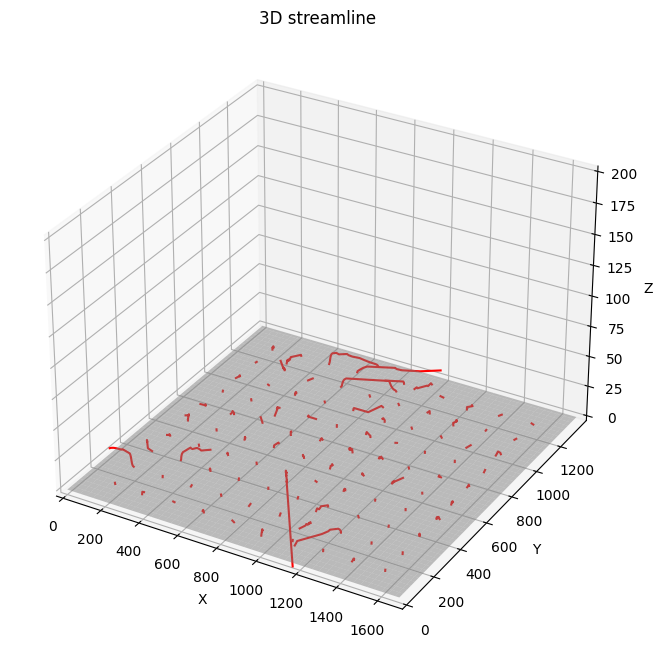

In [82]:
# 定義空間格點 (假設 X, Y, Z 均勻分佈)
Nx, Ny, Nz = Bx.shape
Nz=201
x = np.linspace(0, Nx-1, Nx)  # X 軸範圍為 [0, Nx-1]
y = np.linspace(0, Ny-1, Ny)  # Y 軸範圍為 [0, Ny-1]
z = np.linspace(0, Nz-1, Nz)  # Z 軸範圍為 [0, Nz-1]
# 建立磁場的插值函數
Bx_interp = RegularGridInterpolator((x, y, z), Bx, bounds_error=False, fill_value=None)
By_interp = RegularGridInterpolator((x, y, z), By, bounds_error=False, fill_value=None)
Bz_interp = RegularGridInterpolator((x, y, z), Bz, bounds_error=False, fill_value=None)
def trace_fieldline(start_point, Bx_interp, By_interp, Bz_interp, step=1, n_steps=2000):
    """
    使用 Euler 方法追蹤磁場線
    start_point: 初始點 (x, y, z)
    Bx_interp, By_interp, Bz_interp: 磁場的插值函數
    step: 每步移動距離
    n_steps: 最大步數
    """
    traj = [start_point]  # 存儲磁場線上的點
    point = np.array(start_point)

    for _ in range(n_steps):
        # 取得當前點的磁場值
        B_vector = np.array([
            Bx_interp(point),
            By_interp(point),
            Bz_interp(point)
        ]).flatten()
        # print(B_vector)
        # 若磁場過小，停止追蹤
        norm = np.linalg.norm(B_vector)
        if norm < 1e-6:
            print("braek")
            break

        # 歸一化方向，確保方向正確
        B_vector /= np.abs(B_vector[2])
        point = point + step * B_vector  # 沿磁場方向前進
        traj.append(point.copy())
        # 確保不超出範圍
        if not (x[0] <= point[0] <= x[-1] and y[0] <= point[1] <= y[-1] and z[0] <= point[2] <= z[-1]):
            break
    # print(traj)
    return np.array(traj)

# 3D 繪圖
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 定義幾個磁場線的起點
# x, y 均勻分布在索引範圍內
x_range =  np.round(np.linspace(0, Nx-1, 12)[1:-1])  # 取 10 個點
y_range = np.round(np.linspace(0, Ny-1, 12)[1:-1])  # 取 10 個點

# 生成 (x, y) 網格，z 固定為 0（索引層）
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = np.zeros_like(X_grid)  # 全部 z=0

# 組成 start_points
start_points = np.column_stack((X_grid.ravel(), Y_grid.ravel(), Z_grid.ravel()))

# print(start_points[:20])  # 查看前幾個點

# start_points = [(0, 5, 0), (5, 0, 0), (0, 8, 0), (8, 0, 0)]

for sp in start_points:
    traj = trace_fieldline(sp, Bx_interp, By_interp, Bz_interp)
    ax.plot3D(traj[:, 0], traj[:, 1], traj[:, 2], color='r')

# **繪製 HMI 磁場 (Z=0)**
X_hmi, Y_hmi = np.meshgrid(np.arange(Nx), np.arange(Ny), indexing='ij')  # 使用 HMI 原始大小
print(X_hmi.shape,Nx)
ax.plot_surface(X_hmi, Y_hmi, np.zeros_like(hmi),
                cmap='gray', 
                alpha=0.5, vmin=-200, vmax=200,  edgecolors='none')



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(x[0], x[-1])
ax.set_ylim(y[0], y[-1])
ax.set_zlim(z[0], z[-1])
ax.set_title('3D streamline')

plt.show()
